# Downloading data from google drive

Run this cell only once to download the data. The chunk of code has been taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url and can be ran locally on your jupyter notebook.

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
                
file_id = '1GMnPjRUju5YzZEWL5bk9qCrf90vXWEqD'
destination = 'data_uav.zip'
download_file_from_google_drive(file_id, destination)

from zipfile import ZipFile

with ZipFile('data_uav.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# Reading data from downloaded .mat files

Reading data from mat files. There are a total of 7 tensors with azimuth angle of arrival and departure, zenith angle of angle and departure, time of arrival, received power tensor. All of the above tensors are of dimensions $N_{\rm traj} \times N_{\rm time} \times N_{\rm BS} \times N_{\rm paths} $. The last tensor is the UAV co-ordinate tensor with dimensions $N_{\rm traj} \times N_{\rm time} \times 3 $. The values of all the variables are given below.

**Note:** The number of paths here (25) is the the maximum number of paths that is output by the ray-tracer. It is possible that at some of the points, the number of exisiting paths will be lesser than the maximum number of paths. If this is the case, zeros are padded for these unexisiting paths in the data. These zeros should be filtered out before carrying out analysis.

**Note:** Units of angles are in degrees. Received power is in dBm. Time of arrival is in seconds. The co-ordintes are in meters.

In [ ]:
import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3 #spaced 20 ms apart


mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths


mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths



mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths


mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths



mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3

del mat

# Plotting city layout and a trajectory

Now let's look at the layout of the city. Then choose a random trajectory and show the trajectory superimposed on the binary occupancy grid of the layout.

(-0.5, 1166.5, 874.5, -0.5)

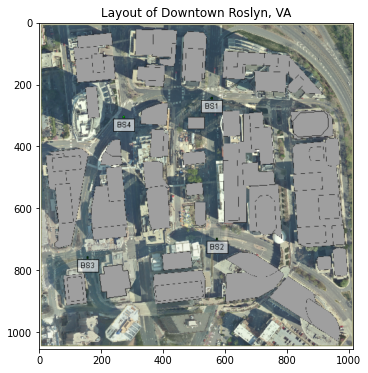

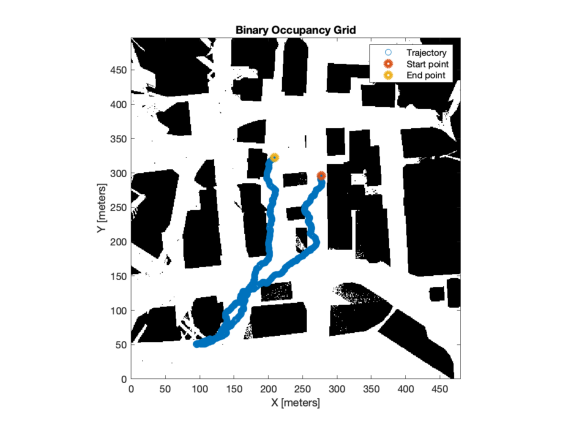

In [ ]:
import random
import matplotlib.pyplot as plt


im = plt.imread('pics.PNG')
plt.figure(figsize=(8, 6))
plt.imshow(im)
plt.title('Layout of Downtown Roslyn, VA')



traj_num = random.randrange(num_trajs)

#print(traj_num)


fig_name = 'FigTrajnum'+str(traj_num+1)+'.png'
im = plt.imread(fig_name)
plt.figure(figsize=(10, 8))
plt.imshow(im)
plt.axis('off')


# Plotting received power

Here we plot the omni-received power of the trajectory for all BS. We choose path number 0 which is the path with the strongest power.

Text(0, 0.5, 'Rx power on the strongest path (dBm)')

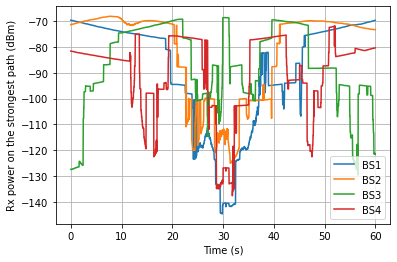

In [ ]:
path_num = 0 # strongest path

rx_powers_omni = rx_power_tensor[traj_num,:,:,path_num]


time_step = 2e-2

time = time_step*np.arange(n_time)
plt.figure()
plt.plot(time,rx_powers_omni)
plt.legend(('BS1','BS2','BS3','BS4'))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Rx power on the strongest path (dBm)')

# Mean time of arrival distribution
Let's look at some temporal characterisitcs of the simulations. We plot CDFs of the mean time of arrival for each BS in nanoseconds. It should be noted that we need to filter out the non-existent paths here.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'CDF')

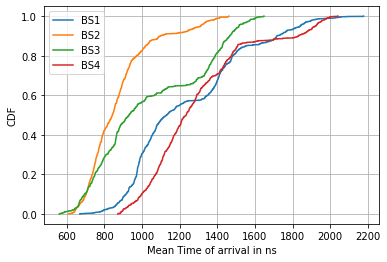

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

time_tensor = toa_tensor[traj_num,:,:,:] # Extracting time of arrivals 
mean_toa_matrix = np.zeros((int(n_time),int(n_bs)))


for i in range(int(n_time)):
    for j in range(int(n_bs)):
        time_array = time_tensor[i,j,:]
        time_array = np.delete(time_array, np.where(time_array == 0)) # filtering non-exsistent paths
        mean_toa_matrix[i,j] = np.mean(time_array)

#print(mean_toa_matrix.shape)
plt.figure()
for i in range(int(n_bs)):
    cdf = ECDF(mean_toa_matrix[:,i]*1e9) # in nanoseconds
    plt.plot(cdf.x,cdf.y)

plt.grid()
plt.legend(('BS1','BS2','BS3','BS4'))
plt.xlabel('Mean Time of arrival in ns')
plt.ylabel('CDF')

# Angle of arrivals and departures distributions
Let's look at some spatial characterisitcs of the simulations. We plot CDFs of the azimuth and elevation departure and arrival angles for each BS. It should be noted that we need to filter out the non-existent paths here.

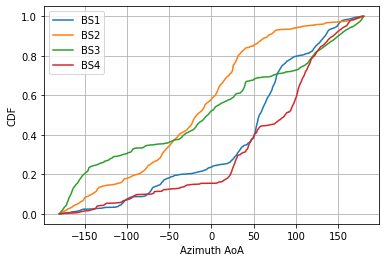

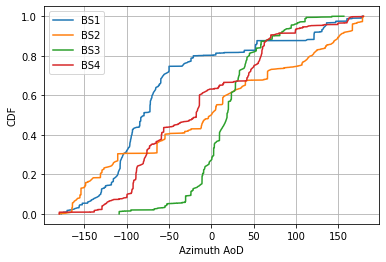

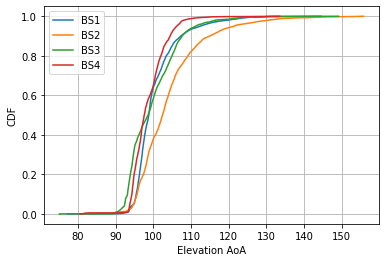

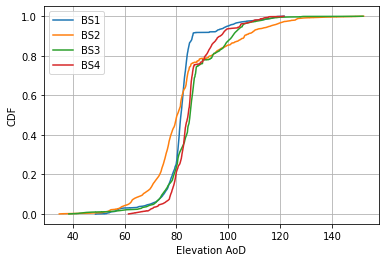

In [ ]:
azimuth_aoa = azimuth_aoa_tensor[traj_num,:,:,:] # Extracting azimuth aoas 
azimuth_aod = azimuth_aod_tensor[traj_num,:,:,:] # Extracting azimuth aods
zenith_aoa = zenith_aoa_tensor[traj_num,:,:,:] # Extracting zenith aoas
zenith_aod = zenith_aod_tensor[traj_num,:,:,:]# Extracting zenith aods

for i in range(int(n_bs)):
    plt.figure(1)
    az_aoa_angles = azimuth_aoa[:,i,:]
    az_aoa_angles = az_aoa_angles.flatten()
    az_aoa_angles = np.delete(az_aoa_angles, np.where(az_aoa_angles == 0))
    cdf = ECDF(az_aoa_angles)
    plt.plot(cdf.x,cdf.y)
    if i==n_bs-1:
        plt.legend(('BS1','BS2','BS3','BS4'))
        plt.grid()
        plt.xlabel('Azimuth AoA')
        plt.ylabel('CDF')
    
    plt.figure(2)
    az_aod_angles = azimuth_aod[:,i,:]
    az_aod_angles = az_aod_angles.flatten()
    az_aod_angles = np.delete(az_aod_angles, np.where(az_aod_angles == 0))
    cdf = ECDF(az_aod_angles)
    plt.plot(cdf.x,cdf.y)
    if i==n_bs-1:
        plt.legend(('BS1','BS2','BS3','BS4'))
        plt.grid()
        plt.xlabel('Azimuth AoD')
        plt.ylabel('CDF')       
    
    plt.figure(3)
    el_aoa_angles = zenith_aoa[:,i,:]
    el_aoa_angles = el_aoa_angles.flatten()
    el_aoa_angles = np.delete(el_aoa_angles, np.where(el_aoa_angles == 0))
    cdf = ECDF(el_aoa_angles)
    plt.plot(cdf.x,cdf.y)
    if i==n_bs-1:
        plt.legend(('BS1','BS2','BS3','BS4'))
        plt.grid()
        plt.xlabel('Elevation AoA')
        plt.ylabel('CDF')
        
    plt.figure(4)
    el_aod_angles = zenith_aod[:,i,:]
    el_aod_angles = el_aod_angles.flatten()
    el_aod_angles = np.delete(el_aod_angles, np.where(el_aod_angles == 0))
    cdf = ECDF(el_aod_angles)
    plt.plot(cdf.x,cdf.y)
    if i==n_bs-1:
        plt.legend(('BS1','BS2','BS3','BS4'))
        plt.grid()
        plt.xlabel('Elevation AoD')
        plt.ylabel('CDF')

